# Advanced Machine Learning - programming assignment 4

*Due: Friday January 30*

*Grading: 15 points total*

**Please fill in:**
* name 1 (student id 1)
* name 2 (student id 2)

### Further instructions:
* For the Questions: Don't make your written answers longer than necessary. Redundant text may be penalized.
* Code quality is considered during the assessment (of assignments 2&4). Use sensible variable names, and make sure your code is properly commented.
* Submit your code in Brightspace only for assignments 2 and 4.
* Make sure to name the submitted file according to your and your collaborators last name. (`submitter_collaborator.ipynb`)
* **Failure to follow these instructions can affect the assignment grade.**

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set. Each of these two parts is worth 5 points.

The PC algorithm will need to keep track of a PDAG. We will represent this PDAG by a numpy array `G` of booleans.

The matrix `G` represents a graph as follows:
* For all `x`, `G[x,x] == False`
* `G[x,y] == False` and `G[y,x] == False` means: no edge between x and y
* `G[x,y] == True` and `G[y,x] == True` means: an undirected edge x&mdash;y
* `G[x,y] == True` and `G[y,x] == False`means: a directed edge x$\to$y

We use `graphviz` to save graphs to different file formats, or show them directly in the notebook. The function `graph_to_graphviz(G, node_names)` converts a numpy array of the form described above to a graph in graphviz format. It requires the `Graphviz` program to be installed: see the instructions on Brightspace.

In [105]:
import numpy as np
import itertools
import graphviz

# Here are some utility functions we'll use later. Don't modify this code.

# Convert a graph in our numpy array representation to a graphviz object
# for visualization.
def graph_to_graphviz(G, node_names):
    n = G.shape[0]
    d = graphviz.Digraph(engine='circo') #'neato')
    for node_name in node_names:
        d.node(node_name)
    for x in range(n):
        for y in range(n):
            if x == y:
                continue
            if G[x,y] and not G[y,x]:
                d.edge(node_names[x], node_names[y])
            elif x < y and G[x,y] and G[y,x]:
                d.edge(node_names[x], node_names[y], dir='none')
    return d

# Recursive helper function for is_d_separated().
def is_d_connected_dfs(mB, pos, w, S, vis):
    (v, dir) = pos
    if v == w:
        return True
    if (dir == 0 and not S[v]) or (dir == 1 and S[v]):
        # traverse backward (dir=0) along an arrow
        next_vs_mask = np.logical_and(mB[v,:], np.logical_not(vis[:,0]))
        if dir == 1:
            # we can't continue on an undirected path in case dir == 1 and S[v]
            next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[:,v]))
        tmp = np.logical_or(vis[:,0], next_vs_mask)
        vis[:,0] = tmp
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 0), w, S, vis):
                return True
    if not S[v]:
        # traverse forward (dir=1) along an arrow
        next_vs_mask = np.logical_and(mB[:,v], np.logical_not(vis[:,1]))
        next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[v,:]))
        vis[:,1] = np.logical_or(vis[:,1], next_vs_mask)
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 1), w, S, vis):
                return True
    return False

# Check if two nodes are d-seperated given S. S must be provided as a mask:
# an array of booleans indicating which nodes are present in the set.
# This algorithm is based on the alternate definition of d-separation,
# where non-simple paths are allowed.
def is_d_separated(G, v, w, S):
    if S[v] or S[w]:
        return True
    mB = G.T
    d = mB.shape[0]
    # vis[v,0]: reachable by path ending in tail
    # vis[v,1]: reachable by path ending in head
    vis = np.zeros((d,2), dtype=bool)
    pos = (v,0)
    vis[pos] = True
    is_d_connected_dfs(mB, pos, w, S, vis)
    if vis[w,0] or vis[w,1]:
        return False
    return True

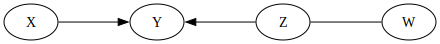

In [106]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

**Tasks 1-3 (1+2.5+2.5 points)**: Here is a Python class for performing the PC algorithm (when an object of this class is created and its `run` function is called). Add the missing code for phase 2, and implement phases 3 and 4. Do not modify other code! In the next section, you'll find some test cases to see if your code runs without errors and does what you expect it to.

In [118]:
def adj(G, x: int):
    # return np.nonzero(G[x])[0]  # ! not sure that this is correct, idk what they exactly mean with ADJACENT??? Directed? Undirected??
    return np.unique(np.concatenate((np.nonzero(G.T[x])[0], np.nonzero(G[x])[0])))

class PC_algorithm:
    def __init__(self, independence_tester, verbose=1):
        # verbose can be 0 (silent), 1 (report independences), or 2 (also report dependences)
        self.independence_tester = independence_tester
        self.n = independence_tester.n_observed
        self.node_names = independence_tester.node_names
        self.verbose = verbose
        self.G = np.logical_not(np.eye(self.n, dtype=bool))
        self.sepset = dict()
    
    def skeleton_search(self):
        # PHASE II: Skeleton search
        # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
        for k in range(self.n-1):
            for x in range(self.n):
                for y in range(self.n):
                    if not self.G[x,y]:
                        continue
                    # Try all subsets S of Adj(x) \ {y} with |S|=k.
                    # S should be a Python list of nodes (possibly an empty list).
                    # Hint: use itertools.combinations

                    adj_x = adj(self.G, x)
                    # print(f'Adj({x})', y, "|", adj_x)
                    adj_x = np.array([neighbor for neighbor in adj_x if neighbor != y])

                    # TASK 1: Your code here (1 point)

                    for S in itertools.combinations(adj_x, k): # replace this line by your code
                        indep = self.independence_tester.test_independence(x, y, S)
                        if indep:
                            if self.verbose >= 1:
                                print(f"independence found: "
                                      f"{self.node_names[x]} and {self.node_names[y]} "
                                      f"given {{{", ".join([self.node_names[v] for v in S])}}}")
                            # Remove this edge.
                            self.G[x,y] = self.G[y,x] = False
                            # We use frozensets as keys in the dictionary self.sepset,
                            # because ordinary sets can't be used as keys to dictionaries.
                            self.sepset[frozenset([x,y])] = S
                            break
                        else:
                            if self.verbose >= 2:
                                print(f"dependence found: "
                                      f"{self.node_names[x]} and {self.node_names[y]} "
                                      f"given {{{", ".join([self.node_names[v] for v in S])}}}")

            # Do we need to continue with larger k?
            max_S_size = np.sum(self.G, axis=0) - 1
            if np.all(max_S_size < k + 1):
                break
        return

    def orient_v_structures(self):
        # PHASE III: Orient v-structures

        # Something to watch out for:
        # If the data are not faithful to any DAG, the algorithm may end up trying
        # to orient a single edge in two different ways. You can choose either
        # orientation if this happens. But make sure not to accidentally delete such an edge!

        # TASK 2: Your code here (2.5 points)

        print("self.sepset", self.sepset)

        for x in range(self.n):
            for y in range(self.n):

                if x == y:
                    continue

                adj_x = adj(self.G, x)

                # if y is adjacent to x, skip
                # no need to test the other case, as it's symmetric in this case
                if y in adj_x:
                    continue

                # get the set of neighbors to both x and y
                adj_y = adj(self.G, y)
                adj_xy = np.intersect1d(adj_x, adj_y)

                if len(adj_xy) == 0:
                    continue

                if frozenset([x, y]) in self.sepset:
                    sepset = self.sepset[frozenset([x, y])]

                    valid_z = [z for z in adj_xy if z not in sepset]

                    # orient the edges X -> Z <- Y
                    for z in valid_z:

                        self.G[x, z] = True
                        self.G[z, x] = False  # no sure about this one

                        self.G[y, z] = True
                        self.G[z, y] = False

        return
    
    def orientation_rules(self):
        # PHASE IV: Orientation rules

        # TASK 3: Your code here (2.5 points)


        for x in range(self.n):
            
            # check whether there is a neighbor of x that has an undirected edge
            adj_x = adj(self.G, x)

            for y in adj_x:
                adj_y = adj(self.G, y)
                adj_y = np.array([neighbor for neighbor in adj_y if neighbor != x])  # set minus x

                if self.G[x, y] and not self.G[y, x]:  # X -> Y
                    # check Y - Z
                    for z in adj_y:
                        if self.G[y, z] and self.G[z, y]:  # undirected edge

                            # if X and Z are adjacent, skip
                            if self.G[z, x] or self.G[x, z]:
                                continue

                            # Rule 1
                            # Orient Y -> Z
                            self.G[y, z] = True
                            self.G[z, y] = False
                        
                        # check Y -> Z
                        elif self.G[y, z] and not self.G[z, y]:  # Y -> Z
                            # check X - Z
                            if self.G[z, x] and self.G[x, z]:

                                # Rule 2
                                # Orient Y -> Z
                                self.G[x, z] = True
                                self.G[z, x] = False

                elif self.G[x, y] and self.G[y, x]:  # 
                    
                    paths_found = 0

                    # Rule 3
                    for w in np.array([neigh for neigh in adj_x if neigh != y]):

                        # check if X - W
                        if self.G[x, w] and self.G[w, x]: 

                            # Check W -> Y
                            if self.G[w, y] and not self.G[y, w]:
                                paths_found += 1

                        # if at least a pair got found, we can orient the
                        if paths_found >= 2:
                            self.G[x, y] = True
                            self.G[y, x] = False
                            break
        
        return

    def run(self):
        # The initialization step has already been performed by the __init__ method.
        # Perform the other phases one by one. Each of the following functions
        # modifies self.G, which represents the graph.
        self.skeleton_search()
        self.orient_v_structures()
        self.orientation_rules()

        return self.G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an *oracle* instead of conditional independence test results from a data set. The oracle knows what the true DAG is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that DAG. In this situation, the PC algorithm will recover the Markov equivalence class of the true DAG.

In [108]:
class IndependenceOracle:
    def __init__(self, true_G, node_names, n_observed=None):
        self.G = true_G
        self.n = true_G.shape[0]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.node_names = node_names
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true DAG for the DAG `G1` we saw before, and for several other DAGs. (You can add more tests to help chase down any bugs.)

independence found: X and Z given {}
independence found: X and W given {}
independence found: Y and W given {Z}
self.sepset {frozenset({0, 2}): (), frozenset({0, 3}): (), frozenset({1, 3}): (np.int64(2),)}
{frozenset({0, 2}): (), frozenset({0, 3}): (), frozenset({1, 3}): (np.int64(2),)}
PASS


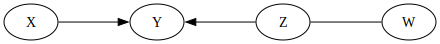

In [109]:
oracle = IndependenceOracle(G1, node_names)
A = PC_algorithm(oracle, verbose=1)
G = A.run()
print(A.sepset)
print("PASS" if np.all(G == G1) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

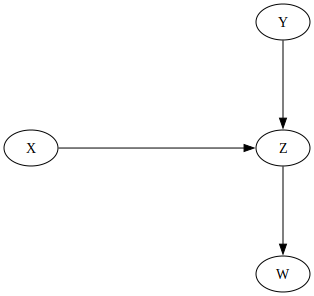

In [110]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

independence found: X and Y given {}
independence found: X and W given {Z}
independence found: Y and W given {Z}
self.sepset {frozenset({0, 1}): (), frozenset({0, 3}): (np.int64(2),), frozenset({1, 3}): (np.int64(2),)}
PASS


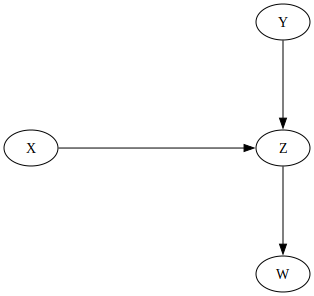

In [111]:
oracle = IndependenceOracle(G2, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G2) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

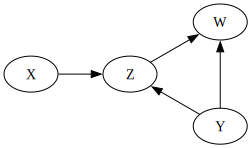

In [112]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

independence found: X and Y given {}
independence found: W and X given {Y, Z}
self.sepset {frozenset({0, 1}): (), frozenset({0, 3}): (np.int64(1), np.int64(2))}
PASS


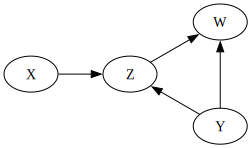

In [113]:
oracle = IndependenceOracle(G3, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G3) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

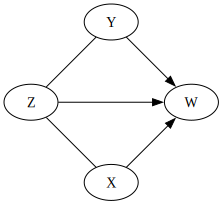

In [114]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: X and Y given {Z}
self.sepset {frozenset({0, 1}): (np.int64(2),)}
PASS


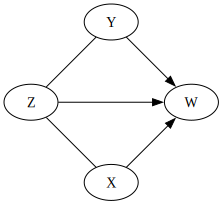

In [115]:
oracle = IndependenceOracle(G4, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G4) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

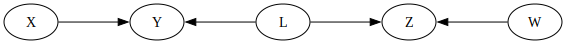

In [116]:
# Example of a case for which no DAG exists that is Markov and faithful to the distribution.
# L is a latent variable that the PC algorithm won't know about. PC's output should be either
# X --? Y --> Z <-- W or
# X --> Y <-- Z ?-- W,
# where the '?'s could be an arrowhead or an undirected edge.
# If there is no edge between Y and Z in your output, this most likely indicates a bug in
# your implementation of phase III.
G5 = np.zeros((5,5), dtype=bool)
G5[0,1] = G5[4,1] = True
G5[3,2] = G5[4,2] = True
graph_to_graphviz(G5, ['X', 'Y', 'Z', 'W', 'L'])

independence found: X and Z given {}
independence found: X and W given {}
independence found: Y and W given {}
self.sepset {frozenset({0, 2}): (), frozenset({0, 3}): (), frozenset({1, 3}): ()}
PASS


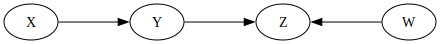

In [117]:
oracle = IndependenceOracle(G5, node_names, n_observed = 4)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if G[0,1] and G[3,2] and (G[1,2] or G[2,1]) and np.sum(np.logical_or(G, G.T)) == 6
      and (G[1,0] == G[1,2] == 0 or G[2,1] == G[2,3] == 0 ) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

**Question 4 (2 points)**:  The claim in the comments for the final test case above says that no DAG on $X,Y,Z,W$ exists that is Markov and faithful to the data distributions that could come out of *most* SCMs that have the five-node `G5` as their graph.

**a)** Explain why no such DAG exists.

**b)** The word "most" above is necessary. Given an example of an SCM with graph `G5` for which a Markov and faithful DAG on $X,Y,Z,W$ *does* exist.

a)

We assume that the latent variable is connected to the graph, as otherwise, the latent variable has no influence on the d-connectedness and d-separation of the observed variables in the graph, and therefore true SCM can be found.

The comment in the final case refers to the d-separation of the latent variable.
In the given graph, we have an open path between {x, y} and {z, w} over the latent variable. As the latent variable is not a collider, conditioning on the latent variable blocks the path between the two subgraphs, and therefore d-separates the two subgraphs.

This is a clear violation of the faithfulness assumption, as {x, y} and {z, w} are independent when conditioning on the latent variable but can be dependent when not conditioning on L. If X and Y are connected in the SCM, then the faithfulness assumption can be broken, as we would have two nodes that are NOT d-separated, but CAN be dependent on each other (when given L).
Therefore, in this case, no DAG exists.

The same argument hold if the latent variable is part of a chain instead of a fork.

Finally, if the latent variable is part of a collider (e.g., X -> L <- Y), then we would observe that {x, y} and {z, w} are independent, although they can be dependent when conditioned on the latent variable, as conditioning on the latent variable would open the path and therefore possibly make both subgraphs dependent, given L.
This violates the Markov assumption, and therefore no DAG exists again.




b)

See explanation above.

The graph 
`X -> Y -> Z <- W`   ` L `
(where L is NOT connected to any other variable)
has a Markov and faithful DAG on X, Y, Z, W.


## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled `experiment`, indicates in which way that cell was prepared. We can think of `experiment=1` as denoting the observational data, and other values of `experiment` (2 through 14) as various interventional datasets.

In [120]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
all_data

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk,experiment
0,26.4,13.2,8.82,18.30,58.80,6.61,17.0,414.0,17.00,44.9,40.0,1
1,35.9,16.5,12.30,16.80,8.13,18.60,32.5,352.0,3.37,16.5,61.5,1
2,59.4,44.1,14.60,10.20,13.00,14.90,32.5,403.0,11.40,31.9,19.5,1
3,73.0,82.8,23.10,13.50,1.29,5.83,11.8,528.0,13.70,28.6,23.1,1
4,33.7,19.8,5.19,9.73,24.80,21.10,46.1,305.0,4.66,25.7,81.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11667,24.8,12.0,2.55,96.50,20.20,25.30,64.4,1715.0,54.70,136.0,141.0,14
11668,107.0,40.3,11.30,311.00,58.80,24.60,47.8,573.0,13.00,25.3,40.7,14
11669,10.4,10.6,10.70,12.50,5.57,14.70,34.0,621.0,11.50,30.5,33.4,14
11670,30.0,35.2,6.79,6.98,1.00,9.47,10.9,269.0,8.20,25.7,34.9,14


We will apply the PC algorithm to just the observational data.

**Task 5 (0.5 point):** Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [121]:
# TASK 5: Your code here (0.5 point)
df_experiment_1 = all_data[all_data['experiment'] == 1].drop(columns=['experiment'])
df_experiment_1

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk
0,26.4,13.2,8.82,18.30,58.80,6.61,17.00,414.0,17.00,44.9,40.00
1,35.9,16.5,12.30,16.80,8.13,18.60,32.50,352.0,3.37,16.5,61.50
2,59.4,44.1,14.60,10.20,13.00,14.90,32.50,403.0,11.40,31.9,19.50
3,73.0,82.8,23.10,13.50,1.29,5.83,11.80,528.0,13.70,28.6,23.10
4,33.7,19.8,5.19,9.73,24.80,21.10,46.10,305.0,4.66,25.7,81.30
...,...,...,...,...,...,...,...,...,...,...,...
848,42.2,27.6,21.50,67.90,12.30,8.28,15.80,562.0,21.90,29.7,8.28
849,62.1,21.7,9.56,6.49,34.30,15.30,23.10,319.0,11.90,35.5,50.90
850,103.0,32.2,10.20,13.20,50.90,5.28,5.62,239.0,14.50,22.9,5.23
851,77.7,23.7,24.80,60.40,44.50,21.50,25.00,289.0,32.20,83.5,27.10


To run the PC algorithm on data, we need to perform (conditional) independence tests. The code below implements a simple test (based on [Spearman correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)). It is not a perfect match for our data, but the alternatives (such as `CMIknn` (Runge, 2018)) are orders of magnitude slower, while Spearman correlation usually already gives decent results.

As a statistical test, a conditional independence test works by computing a p-value. If a conditional independence exists, this p-value will be approximately uniformly distributed on the interval between 0 and 1. If the variables being tested are conditionally dependent, the p-value will be close to 0. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [ ]:
import math
from scipy.stats import beta

class IndependenceTester:
    def __init__(self, data, alpha, verbose=2, n_observed=None):
        # data: a pandas dataframe
        # alpha: the significance level to which the p-values are compared

        self.covariance_matrix = data.corr('spearman').to_numpy()
        self.num_samples = data.shape[0]
        self.n = data.shape[1]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.verbose = verbose
        self.node_names = data.columns
        self.alpha = alpha
        
    def test_independence(self, x, y, S):
        # Compute the partial correlation of x and y given S by inverting a submatrix of the covariance matrix.
        xyS = [x, y]
        xyS.extend(S)
        precision_matrix = np.linalg.inv(self.covariance_matrix[np.ix_(xyS, xyS)])
        corr = -precision_matrix[0,1] / math.sqrt(precision_matrix[0,0] * precision_matrix[1,1])
        # Compute the p-value as in the scipy manual for scipy.stats.pearsonr.
        dist = beta(self.num_samples / 2 - 1, self.num_samples / 2 - 1, loc=-1, scale=2)
        pval = 2 * dist.cdf(-abs(corr))
        test_result = pval > self.alpha
        if self.verbose >= 2 or (self.verbose >= 1 and test_result):
            print(f"test: {self.node_names[x]} and {self.node_names[y]} "
                  f"given {{{", ".join([self.node_names[v] for v in S])}}} "
                  f"-> pval={pval}")
        return test_result

**Task 6 (1 point):** Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should either be connected (i.e. consist of one [connected component](https://en.wikipedia.org/wiki/Component_%28graph_theory%29)), or have just two or three connected components.

Using alpha: 0.0004132231404958678
self.sepset {frozenset({0, 2}): (), frozenset({0, 3}): (), frozenset({0, 4}): (), frozenset({0, 5}): (), frozenset({0, 6}): (), frozenset({0, 7}): (), frozenset({0, 8}): (), frozenset({0, 9}): (), frozenset({0, 10}): (), frozenset({1, 2}): (), frozenset({1, 3}): (), frozenset({1, 4}): (), frozenset({1, 5}): (), frozenset({1, 6}): (), frozenset({1, 7}): (), frozenset({8, 1}): (), frozenset({1, 9}): (), frozenset({1, 10}): (), frozenset({2, 3}): (), frozenset({2, 4}): (), frozenset({2, 5}): (), frozenset({2, 6}): (), frozenset({2, 7}): (), frozenset({8, 2}): (), frozenset({9, 2}): (), frozenset({2, 10}): (), frozenset({3, 5}): (), frozenset({3, 6}): (), frozenset({3, 7}): (), frozenset({8, 3}): (), frozenset({9, 3}): (), frozenset({10, 3}): (), frozenset({4, 5}): (), frozenset({4, 6}): (), frozenset({4, 7}): (), frozenset({8, 4}): (), frozenset({9, 4}): (), frozenset({10, 4}): (), frozenset({8, 5}): (), frozenset({9, 5}): (), frozenset({10, 5}): (), fro

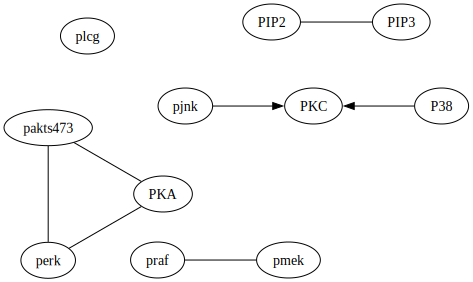

In [153]:
# TASK 6: Your code here (1 point)
alpha = 0.05
num_test = 11**2  # adjusted for the number of tests
alpha /= num_test
print('Using alpha:', alpha)
indep_tester = IndependenceTester(df_experiment_1, alpha=alpha, verbose=0)
pc_algo = PC_algorithm(indep_tester, verbose=0)
G = pc_algo.run()
# G.shape
# G.shape[0]
graph_to_graphviz(G, indep_tester.node_names)

**Question 7 (1 point)**: Examine the observational data to answer the following question: Does it appear that the structural equations of a model generating this data are of one of the forms discussed in lecture 13 (linear / linear Gaussian / additive noise)?
A rigorous statistical test is not required, but you do need to justify your answer.

*Your answer here*

Now let's look at what else is in the dataset: the interventional data corresponding to different experiments. The PC algorithm did not look at this part of the dataset, but these additional experiments can obviously provide valuable information about the causal graph. In the following questions, we will investigate two examples of this. We will use the output of the PC algorithm that you obtained above to give us a rough idea of what the causal graph might look like. **So don't rerun the algorithm when answering the questions below!**

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2020, specifically Tables 2 & 3 and Figure 38(a))

**Task 8 (0.5 point):** Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an `experiment` column, so that you can tell for each row whether it came from the observational or the interventional dataset. The questions refer to these dataframes and to the output of the PC algorithm you obtained above. (Do not run the PC algorithm on these dataframes!)

In [ ]:
# TASK 8: Your code here (0.5 point)

**Question 9 (2 points)**: In the dataframe for experiments 1 and 5, look at PIP2 and a variable adjacent to it in the output of PC (if there is more than one, pick one). Using about 200 words, answer the following questions: Based on looking at one or more plots (like scatterplots or histograms), which do you find more likely: that psitectorigenin directly modifies PIP2, or the neighbouring variable, or both? And what does the data for the two experiments seem to say about the direction of the arrow between PIP2 and this neighbour?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Please put your answer in markdown boxes, not as comments in your code!)

**Question 10 (2 points)**: In the dataframe for experiments 1 and 6, look at perk, pmek, and any (other) variables adjacent to pmek in the output of PC. Assume it is true that adding U0126 produces an intervention on the *activity* of pmek. What would you expect to see in the data if the graph found by PC was correct? Would you propose any changes to that graph based on the data?

Again put your answer (about 200 words) with accompanying plots in new boxes below here.

---

You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [JMLR 21(99):1−108](https://jmlr.org/papers/v21/17-123.html), 2020.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.